In [0]:
#import required library
import math
import dill

import spacy
import seaborn as sns
import matplotlib.ticker as ticker

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator, TabularDataset

import time
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
### initlize Field for source article and target summary
ARTICLE = Field(tokenize='spacy',
                init_token='<sos>',
                eos_token='<eos>',
                lower=True,
                include_lengths=True
                )
SUMMARY = Field(tokenize='spacy',
                init_token='<sos>',
                eos_token='<eos>',
                lower=True,
                )

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#load train, test, val data
train_data, valid_data, test_data = TabularDataset.splits(
                                                    path = "/content/gdrive/My Drive/Attention/data",
                                                    train= 'train.csv',
                                                    validation='val.csv',
                                                    test='test.csv', 
                                                    format='csv',
                                                    fields=[("text",ARTICLE),('headline',SUMMARY)]
                                                        )

In [0]:
#set up vocab for article and summary from train data.
ARTICLE.build_vocab(train_data, min_freq=2)
SUMMARY.build_vocab(train_data, min_freq=2)

In [0]:
#Save article and summary field 
with open("/content/gdrive/My Drive/Attention/model/ARTICLE.Field","wb")as f:
     dill.dump(ARTICLE,f)
with open("/content/gdrive/My Drive/Attention/model/SUMMARY.Field","wb")as f:
     dill.dump(SUMMARY,f)

In [0]:
#Get train, valid, and test itterator
BATCH_SIZE = 64

train_loader, valid_loader, test_loader = BucketIterator.splits(
                                                            (train_data, valid_data, test_data),
                                                            batch_size=BATCH_SIZE,
                                                            sort_within_batch=True,
                                                            sort_key = lambda x:len(x.text),
                                                            device=device
                                                                )

In [0]:
#Encoder class, encodes article to vector

class Encoder(nn.Module):
    
    
    def __init__(self, vocab, embeding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab, embeding_dim)
        self.rnn = nn.GRU(embeding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim*2, decoder_hidden_dim)
        
        self.dropout = nn.Dropout(p=dropout)
   

    def forward(self, text, text_len):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_len)
        packed_outputs, hidden = self.rnn(packed_embedded) 
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return outputs, hidden

In [0]:
# Attention machanism to take encoder hidden states and current decoder state and generate context vector
class Attention(nn.Module):
    
    
    def __init__(self, enc_hid_dim, dec_hid_dim ):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
    

    def forward(self, hidden, encoder_outputs, mask):      
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        attention = self.v(energy).squeeze(2)
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [0]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)        
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_, hidden, encoder_outputs, mask):
    
        input_ = input_.unsqueeze(0)
        embedded = self.dropout(self.embedding(input_))

        atten = self.attention(hidden, encoder_outputs, mask)        
        atten = atten.unsqueeze(1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(atten, encoder_outputs)
        
        weighted = weighted.permute(1, 0, 2)        
        rnn_input_ = torch.cat((embedded, weighted), dim = 2)
            
        output, hidden = self.rnn(rnn_input_, hidden.unsqueeze(0))
              
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0), atten.squeeze(1)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, text_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.text_pad_idx = text_pad_idx
        self.device = device
        
    def create_mask(self, text):
        mask = (text != self.text_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, text, text_len, headline, teacher_forcing_ratio = 0.5):
        batch_size = text.shape[1]
        headline_len = headline.shape[0]
        headline_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(headline_len, batch_size, headline_vocab_size).to(self.device)
      
        encoder_outputs, hidden = self.encoder(text, text_len)
       
        input_ = headline[0,:]
        
        mask = self.create_mask(text)
                
        for t in range(1, headline_len):
            
            output, hidden, _ = self.decoder(input_, hidden, encoder_outputs, mask)           
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio            
            top1 = output.argmax(1)             
            input_ = headline[t] if teacher_force else top1
            
        return outputs

In [0]:
#load saved article and summary field 

with open("/content/gdrive/My Drive/Attention/model/ARTICLE.Field","rb")as f:
     ARTICLE=dill.load(f)
with open("/content/gdrive/My Drive/Attention/model/SUMMARY.Field","rb")as f:
     SUMMARY=dill.load(f)

In [0]:
# model parameters

INPUT_DIM = len(ARTICLE.vocab)
OUTPUT_DIM = len(SUMMARY.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
ARTICLE_PAD_IDX = ARTICLE.vocab.stoi[ARTICLE.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, ARTICLE_PAD_IDX, device).to(device)

In [0]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(50624, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(21467, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=21467, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


In [0]:
#setup optimizer for training model

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [0]:
#setup loss function ignoring pad index

SUMMARY_PAD_IDX = SUMMARY.vocab.stoi[SUMMARY.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = SUMMARY_PAD_IDX)

In [0]:
#function to train model
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        text, text_len = batch.text
        headline = batch.headline
        
        optimizer.zero_grad()
        
        output = model(text, text_len, headline)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        headline = headline[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, headline)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
#function to return val loss
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            text, text_len = batch.text
            headline = batch.headline

            output = model(text, text_len, headline, 0) #turn off teacher forcing
            
            #headline = [headline len, batch size]
            #output = [headline len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            headline = headline[1:].view(-1)

            #headline = [(headline len - 1) * batch size]
            #output = [(headline len - 1) * batch size, output dim]

            loss = criterion(output, headline)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
# training model

N_EPOCHS = 30
N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'checkpoint.pth')
    
    print(f'Epoch: {epoch+1:2} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch:  1 | Time: 15m 29s
	Train Loss: 7.454 | Train PPL: 1725.933
	 Val. Loss: 7.062 |  Val. PPL: 1167.173
Epoch:  2 | Time: 15m 26s
	Train Loss: 6.985 | Train PPL: 1079.823
	 Val. Loss: 6.994 |  Val. PPL: 1090.180
Epoch:  3 | Time: 15m 28s
	Train Loss: 6.903 | Train PPL: 995.337
	 Val. Loss: 6.973 |  Val. PPL: 1066.928
Epoch:  4 | Time: 15m 27s
	Train Loss: 6.846 | Train PPL: 940.514
	 Val. Loss: 6.946 |  Val. PPL: 1038.931
Epoch:  5 | Time: 15m 28s
	Train Loss: 6.802 | Train PPL: 899.948
	 Val. Loss: 6.897 |  Val. PPL: 989.659
Epoch:  6 | Time: 15m 30s
	Train Loss: 6.756 | Train PPL: 859.071
	 Val. Loss: 6.864 |  Val. PPL: 956.768
Epoch:  7 | Time: 15m 29s
	Train Loss: 6.714 | Train PPL: 824.231
	 Val. Loss: 6.838 |  Val. PPL: 932.176
Epoch:  8 | Time: 15m 25s
	Train Loss: 6.668 | Train PPL: 787.177
	 Val. Loss: 6.799 |  Val. PPL: 896.577
Epoch:  9 | Time: 15m 20s
	Train Loss: 6.622 | Train PPL: 751.155
	 Val. Loss: 6.777 |  Val. PPL: 877.478
Epoch: 10 | Time: 15m 21s
	Train Loss: 6

In [0]:
#load best fitted model and calculate test loss
model.load_state_dict(torch.load('checkpoint.pth'))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.890 | Test PPL: 361.461 |


In [0]:
#function to generate summary from saved model
def predict(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if sentence is str:
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention            
        pred_token = output.argmax(1).item()        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [0]:
# function to plot attention scores
def plot_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(32,64))
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = sns.heatmap(attention,cmap='gray', cbar=False, square=True,\
                     yticklabels=translation,xticklabels=sentence) 
    cax.set_yticklabels(cax.get_yticklabels(), rotation = 0, fontsize = 20)
    cax.set_xticklabels(cax.get_xticklabels(), rotation = 90, fontsize = 20)


In [0]:
import matplotlib.pyplot as plt


Text = saudi arabia became the last country in the world to allow women to drive after it lifted the ban on female motorists on sunday . " now every woman has the right to drive a car anywhere in the kingdom , " the country 's traffic authorities spokesman said . the crown prince mohammed bin salman had announced the lifting of the ban last year .

Headline = saudi arabia becomes last country to allow women to drive

Predicted Headline = saudi arabia to to to women to women <eos>

							Attention Plot


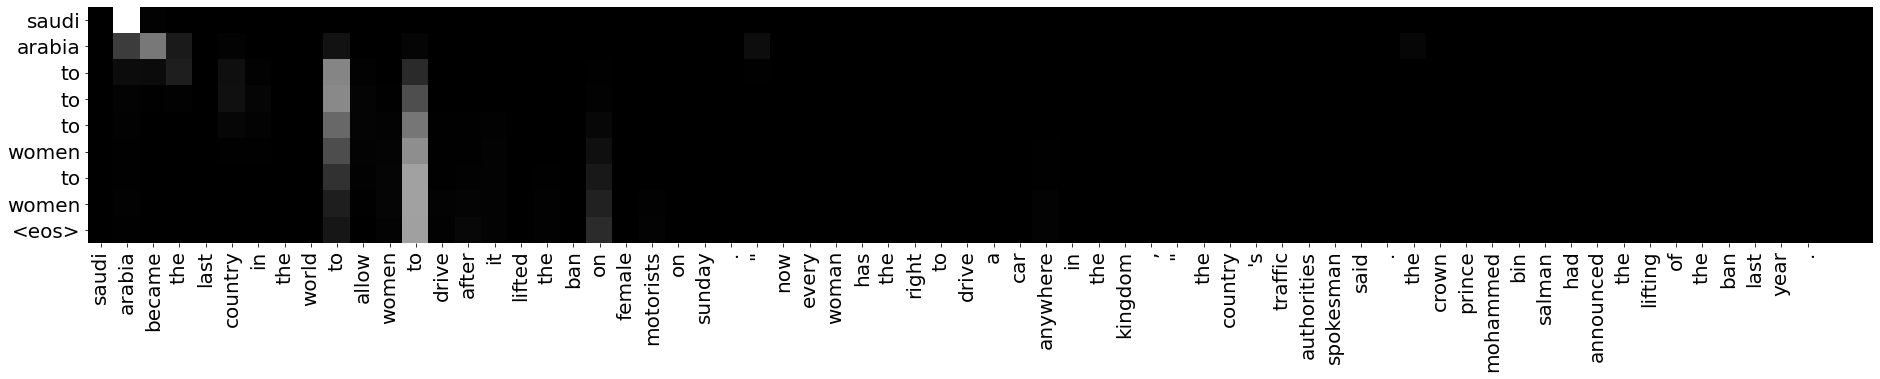

In [0]:
#testing
example_idx = 17

bold_start, bold_end = "\033[1m", "\033[0;0m"
text = vars(test_data.examples[example_idx])['text']
headline = vars(test_data.examples[example_idx])['headline']

print(f'{bold_start}Text{bold_end} = {" ".join(word for word in text)}\n')
print(f'{bold_start}Headline{bold_end} = {" ".join(word for word in headline)}\n')

prediction, attention = predict(text, ARTICLE, SUMMARY, model, device)

print(f'{bold_start}Predicted Headline{bold_end} = {" ".join(word for word in prediction)}')
print("\n\t\t\t\t\t\t\tAttention Plot")
plot_attention(text, prediction, attention)

Text = a chicago - hong kong united airlines flight was diverted to alaska after a passenger reportedly spread faeces all over the plane 's bathrooms and stuffed his shirt in a toilet . the man was met by fbi agents after the flight landed , as the incident took place midair and thereby falls within federal investigators ' jurisdiction . meanwhile , the aircraft was grounded overnight for maintenance .

Headline = flight diverted after man spreads poop in bathrooms

Predicted Headline = man - old man to after after after <eos>

							Attention Plot


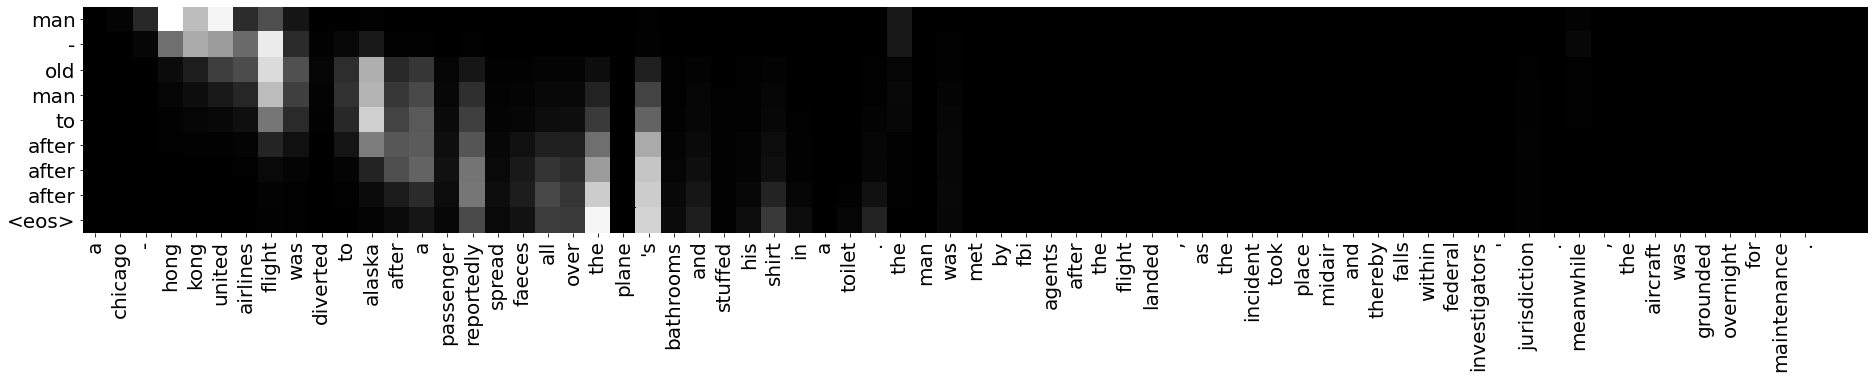

In [0]:
example_idx = 15

bold_start, bold_end = "\033[1m", "\033[0;0m"
text = vars(test_data.examples[example_idx])['text']
headline = vars(test_data.examples[example_idx])['headline']

print(f'{bold_start}Text{bold_end} = {" ".join(word for word in text)}\n')
print(f'{bold_start}Headline{bold_end} = {" ".join(word for word in headline)}\n')

prediction, attention = predict(text, ARTICLE, SUMMARY, model, device)

print(f'{bold_start}Predicted Headline{bold_end} = {" ".join(word for word in prediction)}')
print("\n\t\t\t\t\t\t\tAttention Plot")
plot_attention(text, prediction, attention)